# Functions

In [1]:
def capiq():
    """A helper function to capture data just after bin2res and after reschan"""
    x = ol.capture.capture_iq(1024, 'all', tap_location='rawiq')
    riq=np.array(x)
    x.freebuffer()
    x = ol.capture.capture_iq(1024, 'all', tap_location='iq')
    iq=np.array(x)
    x.freebuffer()
    riq = riq[...,0]+riq[...,1]*1j
    iq = iq[...,0]+iq[...,1]*1j
    # plt.plot(np.abs(riq).mean(0)[:50],'-o')
    print(int(np.abs(riq).max()),int(np.abs(iq).max()))
    return riq,iq

## 1.3 Import Drivers+, Download Overlay <a class="anchor" id="import"></a>

In [2]:
import logging
import sys
logging.basicConfig(stream=sys.stdout)
logging.getLogger('mkidgen3').setLevel('DEBUG')
import pynq
import time
from pynq import PL
import nbwavedrom as wd

import numpy as np
from fpbinary import FpBinary
import matplotlib.pyplot as plt
from scipy.fftpack import fft, fftfreq, fftshift
import scipy.io as sio

import mkidgen3 as g3
import mkidgen3.mkidpynq as mkidpynq
import mkidgen3.util
import mkidgen3.plotting
from mkidgen3.plotting import plot_waveform
import mkidgen3.fccm22_demo
from mkidgen3.daccomb import generate_dac_comb
from mkidgen3.drivers import axiswitch, bintores, capture, ddc, dactable, axififo, rfdc

In [3]:
# Download Overlay, Optionally Configure Clocks
ol = g3.configure('../test_phasematch/phasetest.bit', clocks=True, external_10mhz=True, ignore_version=True)

OSError: Bitstream file ../test_phasematch/phasetest.bit does not exist.

## Generate Resonator Data

The following cells compute the expected downconverted signal from a single MKID resonator. 

In [6]:
class Resonator:
    def __init__(self, res_params):
        self.f0 = res_params['f0']    # resonance frequency
        self.qi = res_params['qi']    # internal quality factor
        self.qc = res_params['qc']    # coupling quality factor
        self.xa = res_params['xa']    # resonance fractional asymmetry
        self.a = res_params['a']     # inductive nonlinearity
        self.alpha = res_params['alpha']   # IQ mixer amplitude imbalance
        self.beta = res_params['beta']    # IQ mixer phase imbalance
        self.gain0 = res_params['gain0']  # gain polynomial coefficients
        self.gain1 = res_params['gain1']
        self.gain2 = res_params['gain2']
        self.phase0 = res_params['phase0']  # phase polynomial coefficients
        self.phase1 = res_params['phase1']
        
    def fsweep(self, fsweep_params):
        self.fc = fsweep_params['fc']   # center frequency [Hz]
        self.points = fsweep_params['points']   # sweep points
        self.span = fsweep_params['span']    # sweep bandwidth [points]
        self.fvec = np.linspace(self.fc-2*self.span/self.points,self.fc+2*self.span/self.points,self.points)
        return(self.fvec)
   
    def s21(self):
        try:
            xm = (self.fvec-self.fc)/self.fc
            xg = (self.fvec-self.f0)/self.f0
        except NameError:
            print("frequency sweep is not defined")
            
        gain = self.gain0+self.gain1*xm+self.gain2*xm**2
        phase = np.exp(1j*(self.phase0+self.phase1*xm))
        q_num = self.qc+2*1j*self.qi*self.qc*(xg+self.xa)
        q_den = self.qi+self.qc+2*1j*self.qi*self.qc*xg
        self.s21=gain*phase*(q_num/q_den)
        return(self.s21)
    
    def plot_trans(self):
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.suptitle(f'{self.f0*1e-9} GHz Simulated Resonator', y=1.02, fontsize = 15)
        
        ax1.plot(self.fvec*1e-9,20*np.log10(np.abs(self.s21)), linewidth=4)
        ax1.set_ylabel('|S21| [dB]')
        ax1.set_xlabel('Frequency [GHz]')
        ax1.set_title('Transmission')
        
        ax2.plot(self.s21.real, self.s21.imag, 'o')
        ax2.set_xlabel('Real(S21)')
        ax2.set_ylabel('Imag(S21)')
        ax2.set_title('IQ Loop')
        
        plt.gcf().set_size_inches(15, 5)
        plt.rcParams.update({'font.size': 12})
        plt.tight_layout()

In [7]:
# Resonator Properties
res_params = {'f0': 4.0012e9,  # resonance frequency [Hz]
               'qi': 100000,  # internal quality factor
               'qc': 30000,  # coupling quality factor
               'xa': 5e-6,  # resonance fractional asymmetry
               'a': 0.8,  # inductive nonlinearity
               'alpha': 1.2,  # IQ mixer amplitude imbalance
               'beta': 0.2,  # IQ mixer phase imbalance
               'gain0': 3.0,  # gain polynomial coefficients
               'gain1': 1000.0,
               'gain2': 500000.0,
               'phase0': 2.0,  # phase polynomial coefficients
               'phase1': -1000.0}

fsweep_params = {'fc': 4.0012e9,   # center frequency [Hz]
                'points': 1000,   # frequency sweep points
                'span': 500e6}   # frequency sweep bandwidth [Hz]

In [8]:
# create resonator, define frequency sweep, compute transmission
res = Resonator(res_params);
res.fsweep(fsweep_params);
res_s21 = res.s21();

In [14]:
res.qc

4000

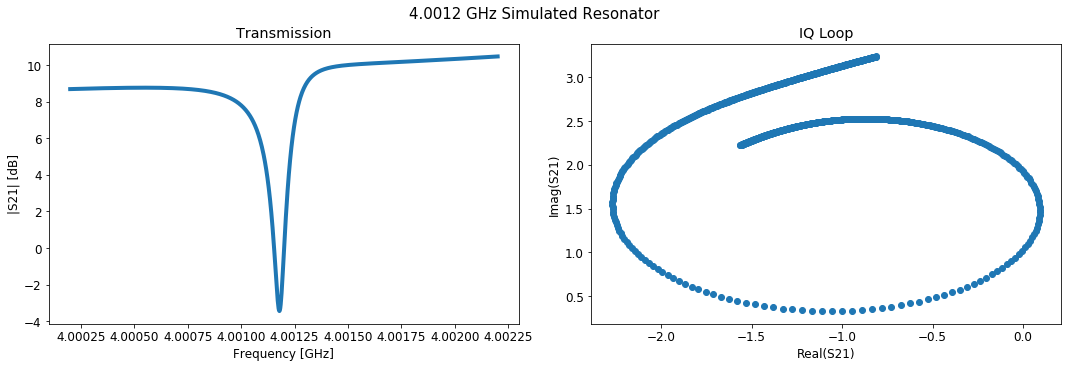

In [248]:
# plot resonator transmission
res.plot_trans()

The following cells demonstrate how to construct an arbitrary waveform and play it out of the DACs.

In [20]:
#Set tones to send (in Hz). Domain is [-2047,2048) MHz. Set the SNR for a noise floor, `'max'` will turn off noise.
tones = np.array([200e6+107e3, 300.5e6-33e3, 400e6+20e3])
amplitudes = np.ones_like(tones)/tones.shape[0]#*.95
snr = 'max'

In [21]:
Ns=2**19 # fill the DAC LUT Table
in_noise = 0
if snr != 'max':
    a_noise = 10**((20*np.log10(1/np.sqrt(2)) - snr)/10)
    in_noise = np.sqrt(a_noise)*(np.random.uniform(-1,1,size=Ns) + 1j*np.random.uniform(-1,1,size=Ns))

In [22]:
# Compute the waveform
dactable = generate_dac_comb(frequencies=tones, n_samples=Ns, sample_rate=4.096e9, amplitudes=amplitudes)
if snr != 'max':
    dactable['iq']+=in_noise
    dactable['iq']/=max(dactable['iq'].real, dactable['iq'].imag)
    pass

In [23]:
# Program URAM and run DAC Table
ol.dac_table_axim_0.replay(dactable['iq'], fpgen='simple',stop_if_needed=True)

At this point, you should be able to measure the DAC output using a Spectrum Analyzer or Oscilloscope. You can also use the RFSoC ADCs! Keep scrolling to see how.

### Capture & Plot DAC Output Using RFSoC ADCs

In [24]:
ol.rfdc.set_qmc(dac=(1,3))

INFO:mkidgen3.drivers.rfdc:RFDCHierarchy does not support switching ADCs
Setting DAC Tile 1, Block 3


{'EnableGain': 0,
 'EnablePhase': 0,
 'EventSource': 0,
 'GainCorrectionFactor': 0.0,
 'OffsetCorrectionFactor': 0,
 'PhaseCorrectionFactor': 0.0}

With the ZCU111 connected in loopback, we can sample the DAC output with the RFSoC ADCs and capture the result to the PL DRAM where we can visualize it in this notebook.

In [25]:
N = Ns # Number of samples to capture (full waveform)
Fs = 4.096e9 # ADC Sample Rate [Hz]
Tc = N/Fs # total collection time (seconds)

In [26]:
# Trigger Capture
adc_capture_data = ol.capture.capture_adc(N, complex=True)
adc_capture_data/=2**16  #Normalize to 1/2 V

DEBUG:mkidgen3.drivers.capture:Capturing 2.0 MB of data @ 16384 MB/s. ETA 0 ms
DEBUG:mkidgen3.drivers.capture:Starting capture of 2097152 bytes (32768 beats) to address 0x500000000 from source adc


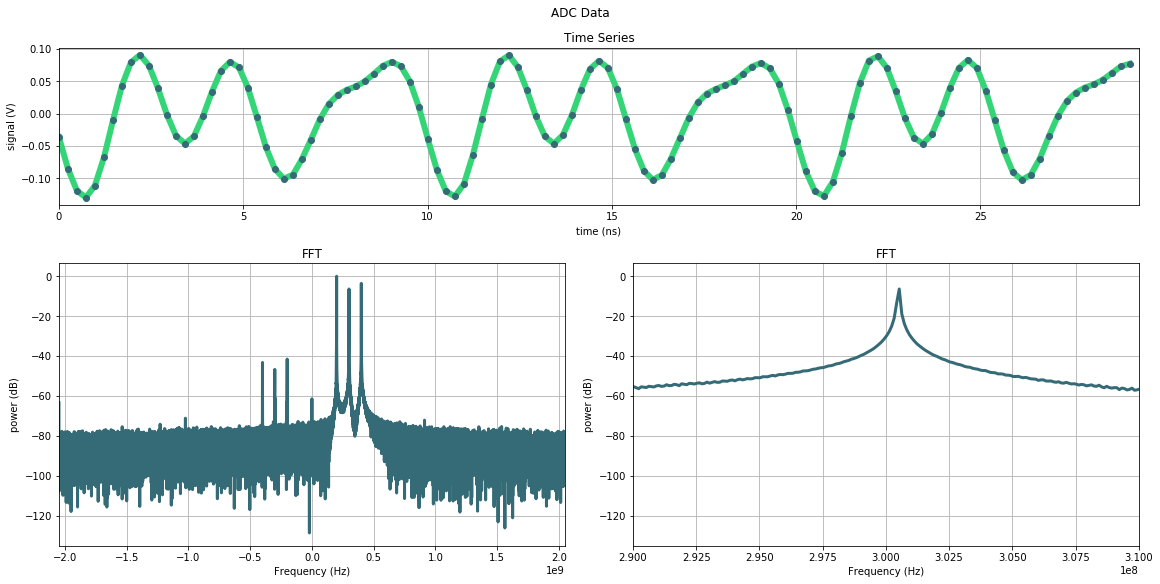

In [27]:
# Plot ADC Data
timerange = (0,120)  # ns
fftrange= (16, 16 + 20*4096)
fftzoom = (2.9e8, 3.1e8)
mkidgen3.plotting.adc_test_plot(adc_capture_data, timerange, fftrange, fftzoom)

## 2.2 Oversampled Polyphase Filter Bank (OPFB) <a class="anchor" id="opfb"></a>

The OPFB is a 4,096-channel, 2/1 oversampled 4 GHz channelizer. It takes in 2, 4.096 GSPS data streams--one from and I ADC and the other from a Q ADC, and produces 4096 2 MHz channels which overlap by 50%. This overlapping feature insures that no matter where a signal exists in-band, it will be able to pass through the channelizer un-attenuated. This IP is the subject of [this publication](https://ieeexplore.ieee.org/document/9336352) and is also documented in a [stand-alone git repo](https://github.com/MazinLab/RFSoC_OPFB).

After being sampled by the ADCs, we can run the data through the OPFB IP and capture the result to the PPL DDR4 for visualization.

### OPFB Capture

<script src="https://cdnjs.cloudflare.com/ajax/libs/wavedrom/2.6.8/skins/default.js" type="text/javascript"></script>
<body onload="WaveDrom.ProcessAll()">
<script type="WaveDrom">
{ signal : [
  { name: "clk",  wave: "p......" },
  { name: "bus",  wave: "x.34.5x",   data: "head body tail" },
  { name: "wire", wave: "0.1..0." },
]}
</script>

In [28]:
# Capture N samples from all 4096 OPFB Bins
opfb_raw = g3.capture_opfb(1024, raw=True)
opfb_fp = opfb_raw[..., 0] + 1j*(opfb_raw[..., 1])  # Convert to complex numbers

DEBUG:mkidgen3.drivers.capture:Capturing 8.0 MB of data @ 16384.0 MBps. ETA 0 ms
DEBUG:mkidgen3.drivers.capture:Starting capture of 8388608 bytes (131072 beats) to address 0x500200000 from source rawiq
DEBUG:mkidgen3.drivers.capture:Capturing 8.0 MB of data @ 16384.0 MBps. ETA 0 ms
DEBUG:mkidgen3.drivers.capture:Starting capture of 8388608 bytes (131072 beats) to address 0x500a00000 from source rawiq


peak in bin: 0


902

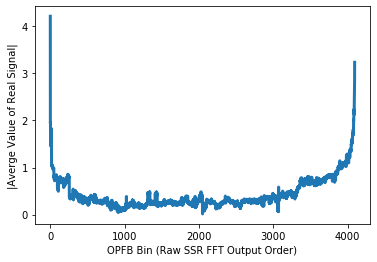

In [29]:
mkidgen3.plotting.find_opfb_tones(opfb_fp)
np.abs(opfb_raw).max()

In [30]:
shift=0

peak in bin: 0


902

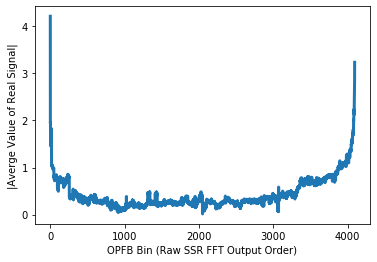

In [31]:
# Bin Offset Correction (Author's are working to fix)
opfb_shifted = np.roll(opfb_fp, shift, axis=1)
mkidgen3.plotting.find_opfb_tones(opfb_shifted)
np.abs(opfb_raw).max()

### Plot OPFB

We expect our 300 MHz tone to be in bin 2348. Because the channelizer is 50% overlapping, we also expect to see the 300.5 MHz tone in that bin as well as the neighboring bin with equal magnitude in each bin. Indeed we see that is the case below.

In [32]:
g3.opfb_bin_number(tones,ssr_raw_order=False)

array([2248, 2348, 2448])

/home/xilinx/src/mkidgen3/mkidgen3/dsp.py:27: RuntimeWarning: divide by zero encountered in log10
  x = 20 * np.log10(np.abs(np.fft.fft(data, axis=0)))


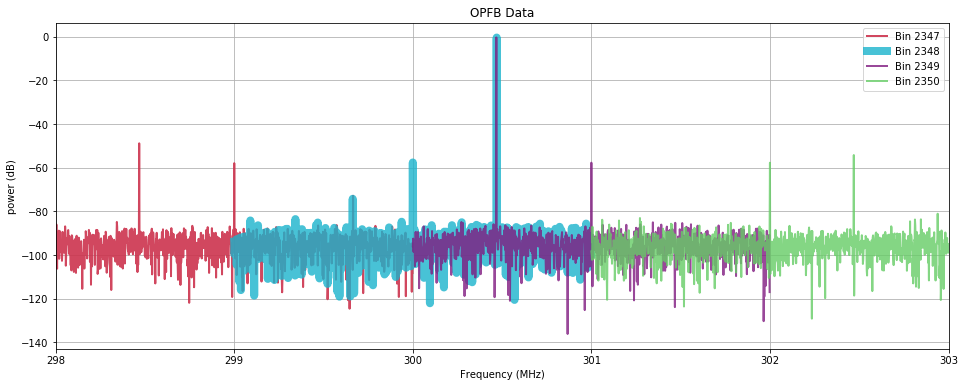

In [33]:
mkidgen3.fccm22_demo.plot_fccm_demo_bins(opfb_shifted)

## 2.3 Bin Select (bin2res) <a class="anchor" id="binselect"></a>

The bin select block is a Vitis HLS IP. The source code along with the exported IP is available [here](https://github.com/MazinLab/opfb-bin-to-res/tree/2021.1). The bin select block caches 8 full spectra from the 4,096-bin opfb channelizer and assigns up to 2048 output bins to user defined channels. The user programs the core over AXI4-Lite to tell it which of the 4096 input OPFB bins to map to which of the 2048 output channels with arbitrary mapping. An example of how we might program the bin select block is shown in the figure below.

<img src="images/Bin_Select_Notebookl.png" alt="drawing" width="600"/>

In the previous cells, we implicitly used the bin select block to capture the OPFB. We programmed bin select to route the first 2048 bins to 2048 corresponding resonator channels and subsequently capture the resonator channels. Then we reprogram bin select to route the second 2048 bins to 2048 corresponding resonator channels and capture the result. Now we will do some experimenting with the bin select block and show how you can arbitrarily assign opfb bins to resonator channels.

Nominally, the 300 MHz tone we generated will be output in bin 300 from the SSR FFT:

In [34]:
g3.opfb_bin_number(tones,ssr_raw_order=True)

array([200, 300, 400])

## 2.2 DDC Time <a class="anchor" id="DDC"></a>

Lets look a bit more closely at the data out of those bins before and after digitally downconverting it.

In [454]:
def capiq():
    """A helper function to capture data just after bin2res and after reschan"""
    x = ol.capture.capture_iq(1024, 'all', tap_location='rawiq')
    riq=np.array(x)
    x.freebuffer()
    x = ol.capture.capture_iq(1024, 'all', tap_location='iq')
    iq=np.array(x)
    x.freebuffer()
    riq = riq[...,0]+riq[...,1]*1j
    iq = iq[...,0]+iq[...,1]*1j
    # plt.plot(np.abs(riq).mean(0)[:50],'-o')
    print(int(np.abs(riq).max()),int(np.abs(iq).max()))
    return riq,iq

Select the bins we've got tones in

In [36]:
bins = np.zeros(2048, dtype=int)
bins[:tones.size] = g3.opfb_bin_number(tones,ssr_raw_order=True)-shift
ol.photon_pipe.reschan.bin_to_res.bins = bins

Configure the DDC to make these tones chill at baseband

In [63]:
g3.configure_ddc(tones, phase_offset=np.array([0, -.9, 0])*np.pi, quantize=True)  #phase goes from [-pi, pi), like tones.size
ol.photon_pipe.reschan.resonator_ddc.tones

DEBUG:mkidgen3:Writing DDC tones...
DEBUG:mkidgen3:DDC tones written.


array([[ 0.109375  ,  0.46875   ,  0.0234375 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -0.89999962,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:
tones_khz=g3.drivers.ddc.tone_increments(tones, quantize=True)*1e3
centers = g3.opfb_bin_center(g3.opfb_bin_number(tones, ssr_raw_order=True), ssr_order=True)

DEBUG:mkidgen3.drivers.capture:Capturing 8.0 MB of data @ 16384.0 MBps. ETA 0 ms
DEBUG:mkidgen3.drivers.capture:Starting capture of 8388608 bytes (131072 beats) to address 0x507200000 from source rawiq
DEBUG:mkidgen3.drivers.capture:Capturing 8.0 MB of data @ 16384.0 MBps. ETA 0 ms
DEBUG:mkidgen3.drivers.capture:Starting capture of 8388608 bytes (131072 beats) to address 0x507a00000 from source iq
903 112


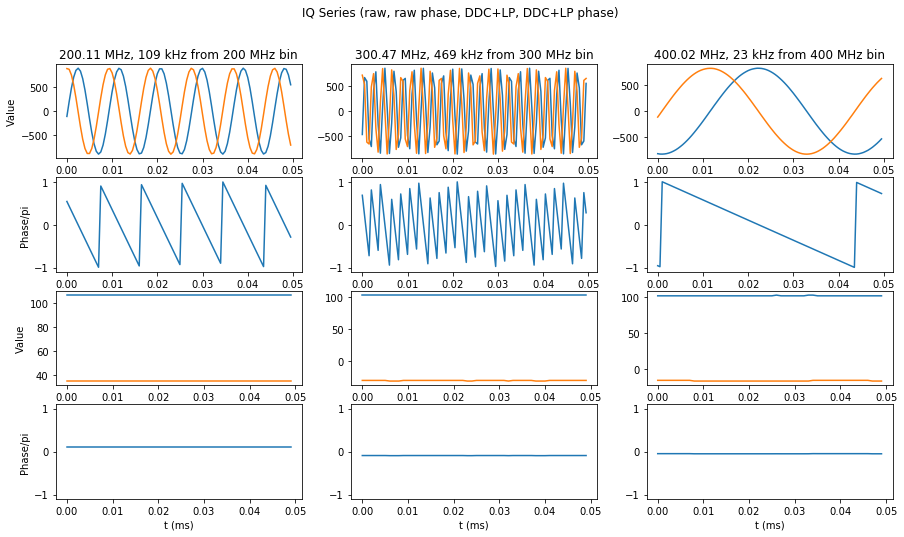

In [64]:
riq,iq=capiq()
fig, axes = plt.subplots(4,3, figsize=(15,8))
for i, ax in enumerate(axes.T):
    plot_waveform(riq[:100, i], 2e6, ax=ax[0], label='Value' if not i else '')
    plt.title(f'{tones[i]/1e6:.2f} MHz, {tones_khz[i]:.0f} kHz from {centers[i]/1e6:.0f} MHz bin')
    plot_waveform(riq[:100, i], 2e6, phase=True, ax=ax[1], label='Phase/pi' if not i else '')
    plot_waveform(iq[:50, i], 1e6, ax=ax[2], label='Value' if not i else '')
    plot_waveform(iq[:50, i], 1e6, phase=True, ax=ax[3], label='Phase/pi' if not i else '')
plt.suptitle('IQ Series (raw, raw phase, DDC+LP, DDC+LP phase)');

Check for scaleing issues by looking at the mean ratio of amplitude before and after ddc with the active channels

In [69]:
(np.abs(riq[:,:3])/np.abs(iq[:,:3])).mean()

8.03242962732353

## 2.3 Phase Time <a class="anchor" id="Phasing"></a>

Lets now look at the phased (CORDIC) data

In [ ]:
def capphase():
    """A helper function to capture data just after bin2res and after reschan"""
    x = ol.capture.capture_phase(1024, 'all', tap_location='rawphase')
    rp=np.array(x)
    x.freebuffer()
    x = ol.capture.capture_phase(1024, 'all', tap_location='phase')
    p=np.array(x)
    x.freebuffer()
    return rp, p

In [ ]:
rpha, pha = capphase()
fig, axes = plt.subplots(3,3, figsize=(15,8))
for i, ax in enumerate(axes.T):
    plot_waveform(iq[:50, i], 1e6, ax=ax[2], label='Value' if not i else '')
    plt.title(f'{tones[i]/1e6:.2f} MHz, {tones_khz[i]:.0f} kHz from {centers[i]/1e6:.0f} MHz bin')
    plot_waveform(iq[:50, i], 1e6, phase=True, ax=ax[3], label='Phase/pi' if not i else '')
    plot_waveform(rpha[:50, i], 1e6, phase=True, ax=ax[3], label='FPGA Phase/pi' if not i else '')
plt.suptitle('IQ Series (raw, raw phase, DDC+LP, DDC+LP phase)');
